In [1]:
import sys,os
sys.path.append(os.path.abspath('.'))  
gpu = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu
os.environ['AUTOGRAPH_VERBOSITY'] = '0'

import transforms3d as tf3d
import matplotlib.pyplot as plt
import time
import random
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow_graphics as tfg
from tensorflow.keras.applications.densenet import preprocess_input


from NOL_model import NOL_network as NOLnet
from NOL_model.NOL_network import simple_mask_error,iou_error,so3_to_mat
import NOL_tools.operations as to
#Rendering process 
import subprocess
import cv2
import NOL_tools.train_io as tio
from NOL_tools.train_io import data_generator



import math
from math import radians
from skimage.transform import resize
from skimage.morphology import binary_dilation
import h5py
import json


In [2]:
class NOL:
    def __init__(self,src_fn,im_h,im_w,cam_K,n_source=6):       
        train_model,backbone,render_gan,Tuning_pose =\
        NOLnet.neural_obj_learning(render_im_w=im_w,render_im_h=im_h,target_im_w=256,target_im_h=256,
                                   cam_K=cam_K)

        for layer in backbone.layers:
            layer.trainable=False  
        weight_fn ="./weights/nol_weights.hdf5"
        train_model.load_weights(weight_fn)
        print("Loading trained model from ",weight_fn)
        for layer in backbone.layers:
            layer.trainable=True

        gradient = K.gradients(Tuning_pose.outputs[0], [Tuning_pose.inputs[4],Tuning_pose.inputs[2]])
        iterate = keras.backend.function(Tuning_pose.inputs, [gradient,Tuning_pose.outputs[0],Tuning_pose.output[3]])

        simple_renderer = NOLnet.simple_render(img_h=im_h,img_w=im_w,cam_K=cam_K) 
        self.iterate = iterate
        self.render_gan = render_gan
        self.simple_renderer = simple_renderer      
        self.im_height=im_h
        self.im_width=im_w
        self.cam_K=cam_K          
        self.t_images=None
        self.t_vert=None
        self.t_faces=None
        self.t_poses=None
        self.t_bboxes=None
        self.t_bboxes_ori=None
        self.gt_masks_full=None
        self.gt_masks=None
        self.t_vert_vis=self.t_vert_vis=np.zeros((1000),bool) 
        self.t_face_angles=[]                        
        self.n_source = n_source
        self.n_src=-1
        self.load_data(src_fn)        
    def get_edge_imgage(self,img_source,render_xyz,c_box,th=0.1):
        render_xyz = render_xyz[c_box[0]:c_box[2],c_box[1]:c_box[3]]
        mask = render_xyz[:,:,2]>0
        dist_x,dist_y = np.gradient(render_xyz[:,:,2])
        depth_edge = np.logical_or(np.abs(dist_x)>th,np.abs(dist_y)>th)
        edge_mask = depth_edge
        edge_mask = resize(edge_mask.astype(np.float32),(256,256))>0
        edge_mask = binary_dilation(edge_mask)>0
        img_source[edge_mask>0]=[0,1,1]
        return img_source
    def display_inputs(self):
        f,ax = plt.subplots(1,self.n_src,figsize=(20,30))
        for fig_id in range(0,self.n_src):      
            simple_xyz = self.simple_renderer.predict([np.array([self.t_vert]),np.array([self.t_faces]),self.t_poses[fig_id:fig_id+1]])
            c_box = self.t_bboxes_ori[fig_id]
            render_xyz = simple_xyz[0][:,:,1:4] 
            img_source = np.copy(self.t_images[fig_id])
            if not(c_box[2]-c_box[0]<10 or c_box[3]-c_box[1]<10):
                img_source = self.get_edge_imgage(img_source,render_xyz,c_box,th=0.1)
            ax[fig_id].imshow(img_source)
            ax[fig_id].axis('off')
    def get_updates(self,dx, x,v,iterations,momentum=0.9,lr=0.001,decay=0.99):
        '''
        grad:gradient
        params: input variable
        v = mu * v - learning_rate * dx # integrate velocity
        x += v # integrate position
        '''    
        if decay > 0:
            lr = lr *(decay**iterations) # (1. / (1. +decay ** iterations))
        v = momentum*v - lr*dx
        x += v
        return x,v
    def load_data(self,fn):        
        train_data = h5py.File(fn, "r")
        self.t_vert = np.array(train_data["vertices_3d"])
        self.t_faces =  np.array(train_data['faces'])
        
        self.t_images =  np.array(train_data['images'])
        self.t_poses = np.array(train_data['poses'])
        t_masks = np.array(train_data['masks'])        
        self.t_bboxes = np.array(train_data['bboxes']).astype(np.float32)
        self.t_bboxes_ori = np.copy(self.t_bboxes)
        self.t_bboxes[:,0]=self.t_bboxes[:,0]/(self.im_height-1)
        self.t_bboxes[:,1]=self.t_bboxes[:,1]/(self.im_width-1)
        self.t_bboxes[:,2]=(self.t_bboxes[:,2]-1)/(self.im_height-1)
        self.t_bboxes[:,3]=(self.t_bboxes[:,3]-1)/(self.im_width-1)
        self.t_bboxes = np.clip(self.t_bboxes,0,1)        
        self.t_bboxes_ori = self.t_bboxes_ori.astype(np.int)
        self.n_src = self.t_images.shape[0]  
        gt_masks_full=[]
        gt_masks=[]
        
        for im_id in range(self.t_images.shape[0]):
                mask = resize(t_masks[im_id].astype(np.float32),(self.t_bboxes_ori[im_id,2]-self.t_bboxes_ori[im_id,0],self.t_bboxes_ori[im_id,3]-self.t_bboxes_ori[im_id,1]))
                mask[mask>0] = 1
                mask[mask<=0] = 0
                full_mask = np.zeros((480,640,1))
                crop_mask = np.zeros((256,256,1))
                crop_mask[:,:,0:1]= t_masks[im_id]>0
                full_mask[self.t_bboxes_ori[im_id,0]:self.t_bboxes_ori[im_id,2],self.t_bboxes_ori[im_id,1]:self.t_bboxes_ori[im_id,3],0:1]=mask
                gt_masks_full.append(full_mask)
                gt_masks.append(crop_mask)    
        self.gt_masks_full = np.array(gt_masks_full)
        self.gt_masks = np.array(gt_masks)  

        if('vertices_uv' in train_data and 'face_angles' in train_data ):
            t_vert_uv = train_data['vertices_uv']
            self.t_vert_vis = (np.sum(t_vert_uv,axis=2)>0).astype(np.float32)
            self.t_face_angles = np.array(train_data['face_angles'])
        else:
            self.update_vert_vis()            
        train_data.close()        
        print("Completed loading data")
        
    def update_vert_vis(self):
        print("Compute visible vertices in each poses...")
        c_vert = np.array(self.t_vert)
        face_obj = np.array(self.t_faces)
        #t_face_angles
        face_angles=[]        
        vert_visb=[]
        for im_id in range(self.n_src):
            pose = self.t_poses[im_id]
            vert_vis = np.ones((c_vert.shape[0]))    
            tf_vert = (np.matmul(pose[:3,:3],c_vert.T)+pose[:3,3:4])
            mesh_vert = np.copy(tf_vert.T)    
            mesh_normal = to.compute_face_normals(mesh_vert,face_obj)    
            bbox_new = self.t_bboxes_ori[im_id]
            
            simple_xyz = self.simple_renderer.predict([np.array([c_vert]),np.array([face_obj]),np.array([pose])])
            render_xyz = simple_xyz[0][:,:,1:4] 
            depth_r = render_xyz[:,:,2]
            xyz = to.getXYZ(depth_r,self.cam_K[0,0],self.cam_K[1,1],self.cam_K[0,2],self.cam_K[1,2])
            normal2,_ = to.get_normal(render_xyz[:,:,2],self.cam_K[0,0],self.cam_K[1,1],self.cam_K[0,2],self.cam_K[1,2])
            mask_effect = depth_r>0 #gt_masks_full[im_id,:,:,0]>0
            mask = depth_r>0
            normal2[np.invert(mask_effect)]=0
            camera_angle = np.copy(xyz)
            face_angle2= np.zeros( (self.im_height,self.im_width))
            valid_xyz = np.linalg.norm(camera_angle,axis=2)
            valid_normal = np.linalg.norm(normal2,axis=2)
            mask_face = np.logical_and(np.logical_and(depth_r>0,valid_xyz>0),valid_normal>0)
            face_angle2[mask_face] = np.sum(camera_angle[mask_face]*normal2[mask_face],axis=1)\
                                            /valid_xyz[mask_face]/valid_normal[mask_face]

            valid_indice = np.zeros((mesh_vert.shape[0]),bool)
            u_temp  =(self.cam_K[0,0]*tf_vert[0]/tf_vert[2] + self.cam_K[0,2]).astype(np.int)
            v_temp  =(self.cam_K[1,1]*tf_vert[1]/tf_vert[2] + self.cam_K[1,2]).astype(np.int)
            valid_idx = np.logical_and(u_temp>=0, u_temp+1<self.im_width)
            valid_idx = np.logical_and(np.logical_and(v_temp>=0, v_temp+1<self.im_height),valid_idx)    
            
            valid_indice[valid_idx] = np.abs(depth_r[v_temp[valid_idx],u_temp[valid_idx]]-tf_vert[2,valid_idx])<0.01
            valid_indice[valid_idx] = np.abs(depth_r[v_temp[valid_idx]+1,u_temp[valid_idx]]-tf_vert[2,valid_idx])<0.01
            valid_indice[valid_idx] = np.abs(depth_r[v_temp[valid_idx],u_temp[valid_idx]+1]-tf_vert[2,valid_idx])<0.01
            valid_indice[valid_idx] = np.abs(depth_r[v_temp[valid_idx]+1,u_temp[valid_idx]+1]-tf_vert[2,valid_idx])<0.01
            
            valid_uvs = np.zeros_like(valid_indice)            
            
            
            valid_uvs[valid_idx] = np.logical_or(valid_uvs[valid_idx],self.gt_masks_full[im_id][v_temp[valid_idx],u_temp[valid_idx],0])
            valid_uvs[valid_idx] = np.logical_or(valid_uvs[valid_idx],self.gt_masks_full[im_id][v_temp[valid_idx]+1,u_temp[valid_idx],0])
            valid_uvs[valid_idx] = np.logical_or(valid_uvs[valid_idx],self.gt_masks_full[im_id][v_temp[valid_idx],u_temp[valid_idx]+1,0])
            valid_uvs[valid_idx] = np.logical_or(valid_uvs[valid_idx],self.gt_masks_full[im_id][v_temp[valid_idx]+1,u_temp[valid_idx]+1,0])
            valid_indice[valid_idx] = np.logical_and(valid_indice[valid_idx],valid_uvs[valid_idx])   
            
            #remove invalid faces
            visible_face_id = (valid_indice[face_obj[:,0]]+valid_indice[face_obj[:,1]]+valid_indice[face_obj[:,2]])>0                            
            invalid_normal_face_id = face_obj[np.logical_and(mesh_normal[:,2]>0,
                                                             np.invert(visible_face_id))]
            valid_indice[invalid_normal_face_id[:,0]]=0
            valid_indice[invalid_normal_face_id[:,1]]=0
            valid_indice[invalid_normal_face_id[:,2]]=0            
        
            vert_visb.append(valid_indice)
            face_angle_crop = resize(face_angle2[bbox_new[0]:bbox_new[2],bbox_new[1]:bbox_new[3]],(256,256))
            face_angles.append(face_angle_crop)
        self.t_vert_vis = np.array(vert_visb)
        self.t_face_angles  = np.array(face_angles)
        print("[Updated] Number of visible vertices:",np.sum(self.t_vert_vis,axis=1))                
    
    def get_batches(self,im_id,target_pose=np.array([0]),integrated=True):
        if(im_id==-1):
            target_pose = target_pose          
            pts = (np.matmul(target_pose[:3,:3],self.t_vert.T)+target_pose[:3,3:4]).T
            proj_u = self.cam_K[0,0]*pts[:,0]/pts[:,2]+self.cam_K[0,2]
            proj_v = self.cam_K[1,1]*pts[:,1]/pts[:,2]+self.cam_K[1,2]
            ct_u = int((np.max(proj_u)+np.min(proj_u))/2)
            ct_v = int((np.max(proj_v)+np.min(proj_v))/2)        
            bbox_ori = np.array([ct_v-128,ct_u-128,ct_v+128,ct_u+128])    
            bbox_ori[:2]=np.maximum(0,bbox_ori[:2])
            bbox_ori[2]=min(bbox_ori[2],self.im_height-1)
            bbox_ori[3]=min(bbox_ori[3],self.im_width-1)
        else:
            target_pose = self.t_poses[im_id]
            bbox_ori = self.t_bboxes_ori[im_id]
        
        t_masks =np.zeros((self.n_src,256,256,1))
        b_img,b_ang_in,b_vert3d,b_faces,\
        b_pose_input,b_vert_visible,b_bbox_train,\
        b_poses,b_bboxes,b_img_gt,uv_target,face_target,img_ids,\
        obj_3d\
        = to.get_tuning_set(target_pose,self.t_images,self.t_poses,self.t_bboxes,self.t_vert,self.t_faces,
                         self.simple_renderer,self.t_vert_vis,self.n_source,self.t_bboxes_ori,t_masks,self.t_face_angles,
                         cam_K=self.cam_K,res_x=self.im_width,res_y=self.im_height,bbox_ori=bbox_ori)
        if not(integrated):
            return b_img,b_ang_in,b_vert3d,b_faces,b_pose_input,\
                   b_vert_visible,b_bbox_train,b_poses,b_bboxes, \
                   self.gt_masks[np.array(img_ids).astype(int)],img_ids
        
        img_recont_norm,int_error,mask_output,proj_output,score_output,feature_in,uv_projection\
        = self.render_gan.predict([b_img,b_ang_in,b_vert3d,b_faces,
                              b_pose_input,b_vert_visible,b_bbox_train,
                              b_poses,b_bboxes])  
        proj_in = np.transpose(proj_output,[1,0,2,3,4]) #pose,batchxHxWxch
        score_output = np.transpose(score_output,[1,0,2,3,4]) #posexbatchxhxwx1
        img_sum = np.sum(score_output*proj_in,axis=1)
        init_img = tio.get_original_image(np.copy(img_sum[0,:,:,:3]))   
                
        mask_render = np.sum(mask_output[:,0,:,:,:1],axis=0,keepdims=True)>0
        f_gt_mask = self.gt_masks[np.array(img_ids).astype(int)]
        f_gt_masks = np.concatenate([mask_render,f_gt_mask],axis=0)        
        
        f_img,f_ang_in,f_vert3d,f_faces,f_pose_input,f_vert_visible,f_bbox_train,f_poses,f_bboxes =\
        to.add_integrated_img(img_sum[0][:,:,:3],face_target,target_pose,uv_target,bbox_ori,\
                           b_img,b_ang_in,b_vert3d,b_faces,b_pose_input,b_vert_visible,b_bbox_train,b_poses,b_bboxes)
        return f_img,f_ang_in,f_vert3d,f_faces,f_pose_input,\
               f_vert_visible,f_bbox_train,f_poses,f_bboxes,f_gt_masks,img_ids
    
    def iteration_pose_paper(self,f_img,f_ang_in,f_vert3d,f_faces,f_pose_input,\
                       f_vert_visible,f_bbox_train,f_poses,f_bboxes,f_gt_masks,img_ids,
                       max_iter,update_rate=1E-4):
        '''
        Original refinement code used for expriments in the paper
        '''
        update_rate = -update_rate #negative gradient direction
        prev_loss=-1     
        init_loss=-1
        actual_iter=0            
        while actual_iter<max_iter:    
            actual_iter+=1
            grad = self.iterate([f_img,f_ang_in,f_vert3d,f_faces,f_pose_input,f_vert_visible,f_bbox_train,
                            f_poses,f_bboxes])
            dgrad = grad[0][0]
            loss = grad[1][0]            
            if(np.abs(loss-prev_loss)<1E-6):
                break
            if(prev_loss!=-1 and prev_loss<loss):
                #if loss increased with the updates: recover and update with a smaller rate
                update_rate*=0.9 #decay update rate and recover old poses
                f_pose_input = np.copy(prev_pose_input)
                dgrad = np.copy(prev_dgrad)
            else:
                if(prev_loss==-1):init_loss=loss                    
                prev_loss=loss
                prev_pose_input = np.copy(f_pose_input)
                prev_dgrad = dgrad            
                update_rate*=0.99 #decay update rate               
            for fig_id in range(1,f_img.shape[0]):
                rx,ry,rz = tf3d.euler.mat2euler(dgrad[fig_id][:3,:3])
                dx,dy,dz =np.maximum(np.minimum(0.005,update_rate* dgrad[fig_id][:3,3]),-0.005)
                tf_adj = np.eye(4)
                tf_adj[:3,:3]=tf3d.euler.euler2mat(update_rate*rx,update_rate*ry,update_rate*rz)
                tf_adj[:3,3]=[dx,dy,dz]            
                f_pose_input[fig_id]=np.matmul(tf_adj,f_pose_input[fig_id])              
        return img_ids,f_pose_input[1:],loss,init_loss
        
    
    
    def render_a_pose(self,target_pose,back_color=[0,0,0],**kwargs):
        #Sample source images for the target pose, and get an initial rendering
        f_img,f_ang_in,f_vert3d,f_faces,f_pose_input_so3,\
        f_vert_visible,f_bbox_train,f_poses,f_bboxes,f_gt_masks,img_ids=\
        self.get_batches(-1,target_pose)   

        #Local pose refinement for the target pose -> b_pose_input 
        img_ids,pose_new,loss,init_loss = self.iteration_pose_paper(f_img,f_ang_in,f_vert3d,f_faces,f_pose_input_so3,\
                                     f_vert_visible,f_bbox_train,f_poses,f_bboxes,f_gt_masks,img_ids,
                                     **kwargs)         
        #Rendering the final image with the updated pose
        img_recont_norm,int_error,mask_output,proj_output,score_output,feature_in,uv_projection\
        = self.render_gan.predict([f_img[1:],f_ang_in[1:],f_vert3d[1:],f_faces[1:],
                                  pose_new,f_vert_visible[1:],f_bbox_train[1:],
                                  f_poses[1:],f_bboxes[1:]])              
        img_sum = np.sum(score_output*proj_output,axis=0)
        img = tio.get_original_image(np.copy(img_sum[0,:,:,:3]))
        if(np.sum(np.array(back_color))>0):
            simple_xyz = self.simple_renderer.predict([np.array([self.t_vert]),
                                            np.array([self.t_faces]),
                                            np.array([target_pose])])
            bbox=f_bbox_train[0].astype(int)
            mask = simple_xyz[0,:,:,3]>0
            img[np.invert(mask[bbox[0]:bbox[2],bbox[1]:bbox[3]])]=back_color
            img[np.invert(f_gt_masks[0,:,:,0]>0)]=back_color
        return img
    

In [3]:
#src_fn,im_h,im_w,cam_K):  
dataset="linemod"
if(dataset=="smot"):
    cam_K = np.array([[538.391033533567,0,315.3074696331638],
                      [0,538.085452058436,233.0483557773859],
                      [0,0,1]])
    fx = cam_K[0,0]
    fy = cam_K[1,1]
    cx = cam_K[0,2]
    cy = cam_K[1,2]
    im_h=480
    im_w=640
elif(dataset=="linemod"):
    cam_K = np.array([[572.4114 ,   0.     , 325.2611 ],
                      [  0.     , 573.57043, 242.04899],
                      [  0.     ,   0.     ,   1.     ]])
    im_w= 640
    im_h =  480
    

else:
    im_w = 640
    im_h = 480
    cam_K=np.array([[614.0,   0.   , 639/2],
                     [  0.   , 614.0, 479/2],
                     [  0.   ,   0.   ,   1. ]])

#src_fn = "/root/ssd/HO3D/021_bleach_cleanser.hdf5" #""#"./sample_data/ho3d/010_potted_meat_can.hdf5"
#src_fn="/root/ssd/SeeThrough_Data/try4_no_headmove/test_data_ycb/obj_03.hdf5"
src_fn = "/root/ssd/neural_obj_bop/4/train.hdf5"
m_NOL = NOL(src_fn,im_h=im_h,im_w=im_w,cam_K=cam_K)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected indent (<unknown>, line 40)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected indent (<unknown>, line 40)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected indent (<unknown>, line 40)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected indent (<unknown>, line 40)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Lin

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Completed loading data


In [36]:
print("Compute visible vertices in each poses...")
from sklearn.neighbors import NearestNeighbors
c_vert = np.array(m_NOL.t_vert)
face_obj = np.array(m_NOL.t_faces)
#t_face_angles
face_angles=[]        
vert_visb=[]
for im_id in range(m_NOL.n_src):
    pose = m_NOL.t_poses[im_id]
    vert_vis = np.ones((c_vert.shape[0]))    
    tf_vert = (np.matmul(pose[:3,:3],c_vert.T)+pose[:3,3:4])
    mesh_vert = np.copy(tf_vert.T)        
    mesh_normal = to.compute_face_normals(mesh_vert,face_obj)    
    
    bbox_new = m_NOL.t_bboxes_ori[im_id]
    simple_xyz = m_NOL.simple_renderer.predict([np.array([c_vert]),np.array([face_obj]),np.array([pose])])
    render_xyz = simple_xyz[0][:,:,1:4] 
    depth_r = render_xyz[:,:,2]
    xyz = to.getXYZ(depth_r,m_NOL.cam_K[0,0],m_NOL.cam_K[1,1],m_NOL.cam_K[0,2],m_NOL.cam_K[1,2])
    normal2,_ = to.get_normal(render_xyz[:,:,2],m_NOL.cam_K[0,0],m_NOL.cam_K[1,1],m_NOL.cam_K[0,2],m_NOL.cam_K[1,2])
    mask_effect = depth_r>0 #gt_masks_full[im_id,:,:,0]>0
    mask = depth_r>0
    normal2[np.invert(mask_effect)]=0
    camera_angle = np.copy(xyz)
    face_angle2= np.zeros( (m_NOL.im_height,m_NOL.im_width))
    valid_xyz = np.linalg.norm(camera_angle,axis=2)
    valid_normal = np.linalg.norm(normal2,axis=2)
    
    mask_face = np.logical_and(np.logical_and(depth_r>0,valid_xyz>0),valid_normal>0)
    face_angle2[mask_face] = np.sum(camera_angle[mask_face]*normal2[mask_face],axis=1)\
                                    /valid_xyz[mask_face]/valid_normal[mask_face]

    valid_indice = np.zeros((mesh_vert.shape[0]),bool)
    '''
    u_temp  =(m_NOL.cam_K[0,0]*tf_vert[0]/tf_vert[2] + m_NOL.cam_K[0,2]).astype(np.int)
    v_temp  =(m_NOL.cam_K[1,1]*tf_vert[1]/tf_vert[2] + m_NOL.cam_K[1,2]).astype(np.int)
    valid_idx = np.logical_and(u_temp>=0, u_temp+1<m_NOL.im_width)
    valid_idx = np.logical_and(np.logical_and(v_temp>=0, v_temp+1<m_NOL.im_height),valid_idx)    

    valid_indice[valid_idx] = np.abs(depth_r[v_temp[valid_idx],u_temp[valid_idx]]-tf_vert[2,valid_idx])<0.01
    valid_indice[valid_idx] = np.abs(depth_r[v_temp[valid_idx]+1,u_temp[valid_idx]]-tf_vert[2,valid_idx])<0.01
    valid_indice[valid_idx] = np.abs(depth_r[v_temp[valid_idx],u_temp[valid_idx]+1]-tf_vert[2,valid_idx])<0.01
    valid_indice[valid_idx] = np.abs(depth_r[v_temp[valid_idx]+1,u_temp[valid_idx]+1]-tf_vert[2,valid_idx])<0.01

    valid_uvs = np.zeros_like(valid_indice)  
    valid_uvs[valid_idx] = np.logical_or(valid_uvs[valid_idx],m_NOL.gt_masks_full[im_id][v_temp[valid_idx],u_temp[valid_idx],0])
    valid_uvs[valid_idx] = np.logical_or(valid_uvs[valid_idx],m_NOL.gt_masks_full[im_id][v_temp[valid_idx]+1,u_temp[valid_idx],0])
    valid_uvs[valid_idx] = np.logical_or(valid_uvs[valid_idx],m_NOL.gt_masks_full[im_id][v_temp[valid_idx],u_temp[valid_idx]+1,0])
    valid_uvs[valid_idx] = np.logical_or(valid_uvs[valid_idx],m_NOL.gt_masks_full[im_id][v_temp[valid_idx]+1,u_temp[valid_idx]+1,0])
    valid_indice[valid_idx] = np.logical_and(valid_indice[valid_idx],valid_uvs[valid_idx])   

    #remove invalid faces
    visible_face_id = (valid_indice[face_obj[:,0]]+valid_indice[face_obj[:,1]]+valid_indice[face_obj[:,2]])>0                            
    invalid_normal_face_id = face_obj[np.logical_and(mesh_normal[:,2]>0,
                                                     np.invert(visible_face_id))] #invisible vertices and normal is not facing camera
    valid_indice[invalid_normal_face_id[:,0]]=0
    valid_indice[invalid_normal_face_id[:,1]]=0
    valid_indice[invalid_normal_face_id[:,2]]=0            
    '''
    xyz=xyz[mask]
    nn = NearestNeighbors(n_neighbors=50).fit(mesh_vert)                    
    dists,indices = nn.kneighbors(xyz)
    vert_mask = np.zeros((mesh_vert.shape[0]),np.uint8)
    valid_indice = np.zeros((mesh_vert.shape[0]),bool)
    for pt_idx in range(xyz.shape[0]):
        valid_ver = indices[pt_idx,dists[pt_idx,:]<0.01]                
        vert_mask[valid_ver]=1            
    visible_face_id = (vert_mask[face_obj[:,0]]+vert_mask[face_obj[:,1]]+vert_mask[face_obj[:,2]])>0                    
    valid_normal_face_id = mesh_normal[:,2]<=0
    valid_faces =face_obj[np.logical_and(visible_face_id,valid_normal_face_id)]
    valid_indice[valid_faces[:,0]]=1
    valid_indice[valid_faces[:,1]]=1
    valid_indice[valid_faces[:,2]]=1 
    
    vert_visb.append(valid_indice)
    face_angle_crop = resize(face_angle2[bbox_new[0]:bbox_new[2],bbox_new[1]:bbox_new[3]],(256,256))
    face_angles.append(face_angle_crop)
m_NOL.t_vert_vis = np.array(vert_visb)
m_NOL.t_face_angles  = np.array(face_angles)
print("[Updated] Number of visible vertices:",np.sum(m_NOL.t_vert_vis,axis=1))                


Compute visible vertices in each poses...
[Updated] Number of visible vertices: [6729 7904 9194 8127 9133 9770 9960 7687 8560 8473 9030 9843 9102 8277
 8774]


In [34]:
import open3d as o3d

ori_mesh =o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(mesh_vert),
                       triangles=o3d.utility.Vector3iVector(face_obj.astype(np.int32)))
xyz_mesh =o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(xyz))
    
    
o3d.visualization.draw_geometries([ori_mesh,xyz_mesh])

In [4]:
#src_fn="/root/ssd/HO3D/006_mustard_bottle.hdf5"
#m_NOL.load_data(fn=src_fn)

#result_dir = "./results/mustard_bottle"
#if not(os.path.exists(result_dir)):os.makedirs(result_dir)
update_rate=1E-5 #for LineMOD and SMOT / Ho3d?
pose_list = np.load("./sample_data/pose_target_lm.npy")
total_ids = np.arange(np.arange(0,360,5).shape[0]*np.arange(0,90,5).shape[0])
azi_ele = total_ids.reshape(72,18)
ele_azi = np.transpose(azi_ele).reshape(-1)
img_cnt=0
for elaz_id in np.arange(72*3,ele_azi.shape[0],5):#[target_pose_id]:
    pose_id = ele_azi[elaz_id]
    pose = pose_list[pose_id]
    target_pose=np.eye(4)
    target_pose[:3,:3] =pose[:3,:3]
    target_pose[:3,3]=[0,0,0.7]
    img = m_NOL.render_a_pose(target_pose,max_iter=50,update_rate=update_rate,back_color=[1,1,1]) #done
    img_cv2 = np.clip((img[:,:,::-1]*255).astype(np.uint8),0,255)
    #cv2.imwrite(os.path.join(result_dir,"{:04d}.png".format(img_cnt)),img_cv2)
    img_cnt+=1
    plt.imshow(img)
    break

KeyboardInterrupt: 

Completed loading data


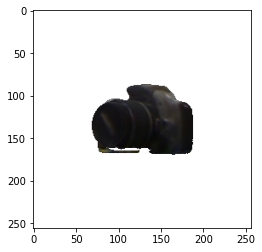

In [4]:

#src_fn="/root/ssd/HO3D/006_mustard_bottle.hdf5"
src_fn = "/root/ssd/neural_obj_bop/4/train.hdf5"
m_NOL.load_data(fn=src_fn)

#result_dir = "./results/mustard_bottle"
#if not(os.path.exists(result_dir)):os.makedirs(result_dir)
update_rate=1E-5 #for LineMOD and SMOT / Ho3d?
pose_list = np.load("./sample_data/pose_target_lm.npy")
total_ids = np.arange(np.arange(0,360,5).shape[0]*np.arange(0,90,5).shape[0])
azi_ele = total_ids.reshape(72,18)
ele_azi = np.transpose(azi_ele).reshape(-1)
img_cnt=0
for elaz_id in [10]:#np.arange(72*3,ele_azi.shape[0],5):#[target_pose_id]:
    pose_id = ele_azi[elaz_id]
    pose = pose_list[pose_id]
    target_pose=np.eye(4)
    target_pose[:3,:3] =pose[:3,:3]
    target_pose[:3,3]=[0,0,0.7]
    img = m_NOL.render_a_pose(target_pose,max_iter=50,update_rate=update_rate,back_color=[1,1,1]) #done
    img_cv2 = np.clip((img[:,:,::-1]*255).astype(np.uint8),0,255)
    #cv2.imwrite(os.path.join(result_dir,"{:04d}.png".format(img_cnt)),img_cv2)
    img_cnt+=1
    plt.imshow(img)
    break

In [14]:
src_fn="/root/ssd/HO3D/037_scissors.hdf5"
#src_fn = "/root/ssd/HO3D/021_bleach_cleanser.hdf5" 

m_NOL.load_data(fn=src_fn)
m_NOL.n_src=m_NOL.t_images.shape[0]


Completed loading data


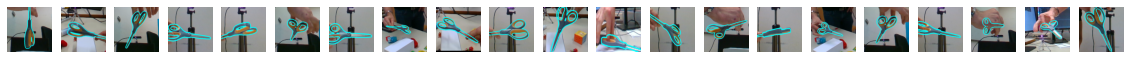

In [15]:
f,ax = plt.subplots(1,m_NOL.n_src,figsize=(20,30))
for fig_id in range(0,m_NOL.n_src):      
    simple_xyz = m_NOL.simple_renderer.predict([np.array([m_NOL.t_vert]),np.array([m_NOL.t_faces]),m_NOL.t_poses[fig_id:fig_id+1]])
    c_box = m_NOL.t_bboxes_ori[fig_id]
    render_xyz = simple_xyz[0][:,:,1:4] 
    img_source = np.copy(m_NOL.t_images[fig_id])
    if not(c_box[2]-c_box[0]<10 or c_box[3]-c_box[1]<10):
        img_source = m_NOL.get_edge_imgage(img_source,render_xyz,c_box,th=0.1)
    ax[fig_id].imshow(img_source)
    ax[fig_id].axis('off')

In [ ]:
#src_fn="/root/ssd/SeeThrough_Data/TfC_dataset/train/seq2/test_data_ycb/obj_08.hdf5"
#m_NOL.load_data(fn=src_fn)
#m_NOL.n_src=m_NOL.t_images.shape[0]
    

Completed loading data


KeyboardInterrupt: 

In [9]:
m_NOL.t_vert_vis.shape

(1000,)

In [6]:
f_img,f_ang_in,f_vert3d,f_faces,f_pose_input,\
f_vert_visible,f_bbox_train,f_poses,f_bboxes,f_gt_masks,img_ids=\
m_NOL.get_batches(-1,target_pose)   

#Local pose refinement for the target pose -> b_pose_input 

img_ids,pose_new,loss,init_loss = m_NOL.iteration_pose_paper(f_img,f_ang_in,f_vert3d,f_faces,f_pose_input,\
                             f_vert_visible,f_bbox_train,f_poses,f_bboxes,f_gt_masks,img_ids,
                            max_iter=25,update_rate=1E-5)         
#Rendering the final image with the updated pose
img_recont_norm,int_error,mask_output,proj_output,score_output,feature_in,uv_projection\
= m_NOL.render_gan.predict([f_img[1:],f_ang_in[1:],f_vert3d[1:],f_faces[1:],
                          pose_new,f_vert_visible[1:],f_bbox_train[1:],
                          f_poses[1:],f_bboxes[1:]])              
img_sum = np.sum(score_output*proj_output,axis=0)
img = tio.get_original_image(np.copy(img_sum[0,:,:,:3]))

#img[np.invert(f_gt_masks[0,:,:,0]>0)]=[1,1,1]

plt.imshow(img)

ValueError: operands could not be broadcast together with shapes (18995,) (1000,) 

In [6]:
train_data = h5py.File(src_fn, "r")
print(train_data.keys())
t_vert_uv = train_data['vertices_uv']
t_vert_vis = (np.sum(t_vert_uv,axis=2)>0).astype(np.float32)

train_data.close()
print(t_vert_vis.shape)

<KeysViewHDF5 ['bboxes', 'cam_K', 'face_angles', 'faces', 'im_height', 'im_width', 'images', 'masks', 'poses', 'vertices_3d', 'vertices_uv']>
(15, 18995)


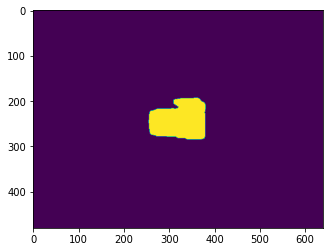

In [30]:
plt.imshow(mask)

In [26]:
f_bbox_train

array([[111., 190., 367., 446.],
       [106., 191., 362., 447.],
       [ 40., 195., 296., 451.],
       [189., 251., 445., 507.],
       [ 49., 155., 305., 411.],
       [119., 205., 375., 461.],
       [ 43., 163., 299., 419.]])

In [27]:
f_bboxes

array([[[0.23125   , 0.296875  , 0.76458335, 0.696875  ]],

       [[0.23125   , 0.296875  , 0.76458335, 0.696875  ]],

       [[0.23125   , 0.296875  , 0.76458335, 0.696875  ]],

       [[0.23125   , 0.296875  , 0.76458335, 0.696875  ]],

       [[0.23125   , 0.296875  , 0.76458335, 0.696875  ]],

       [[0.23125   , 0.296875  , 0.76458335, 0.696875  ]],

       [[0.23125   , 0.296875  , 0.76458335, 0.696875  ]]], dtype=float32)